# Phase 4: Evaluation Pipeline over Synthetic Data

## 4.0. Path & Model setup

In [62]:
import numpy as np
import pandas as pd
from pathlib import Path

from scipy.stats import ks_2samp
from scipy.spatial.distance import cdist

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

import json

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

BASE_SYN_DIR = Path("../output/synthetic_generation")
EVAL_BASE = Path("../output/synthetic_evaluation")
EVAL_BASE.mkdir(parents=True, exist_ok=True)

# Models
MODEL_INFO = {
    "mixup":  "Mixup",
    "corr":   "Correlation Sampling",
    "wgangp": "WGAN-GP",
    "copula": "Gaussian Copula",
    "interp": "Classwise Interpolation",
}

# Frequency band feature columns
BAND_COLS = ["Delta", "Theta", "Alpha", "Beta", "Gamma"]

# Canonical condition codes we care about
CANONICAL_CONDITIONS = ["S1", "S2_match", "S2_nomatch"]

### 4.0.1. Normalize condtions of real and synthetic data

In [ ]:
def load_model_data(model_key: str):
    """
    Load real and synthetic CSVs for a given model.
    Returns:
      real_X, real_y, real_c, syn_X, syn_y, syn_c
    """
    folder = BASE_SYN_DIR / model_key

    real_fp = folder / f"{model_key}_real.csv"
    syn_fp  = folder / f"{model_key}_syn.csv"

    real_df = pd.read_csv(real_fp)
    syn_df  = pd.read_csv(syn_fp)

    # detect condition column name
    cond_col_real = "condition" if "condition" in real_df.columns else "matching_condition"
    cond_col_syn  = "condition" if "condition" in syn_df.columns  else "matching_condition"

    # Basic checks for band + label + condition
    missing_real = [col for col in BAND_COLS + ["label", cond_col_real] if col not in real_df.columns]
    missing_syn  = [col for col in BAND_COLS + ["label", cond_col_syn] if col not in syn_df.columns]
    if missing_real:
        print(f"[WARN] {model_key}_real missing columns: {missing_real}")
    if missing_syn:
        print(f"[WARN] {model_key}_syn missing columns: {missing_syn}")

    # Features
    real_X = real_df[BAND_COLS].to_numpy()
    syn_X  = syn_df[BAND_COLS].to_numpy()

    # Labels
    real_y = real_df["label"].to_numpy().astype(int)
    syn_y  = syn_df["label"].to_numpy().astype(int)

    # condition normalization
    def normalize_condition(series):
        def norm(x):
            if pd.isna(x):
                return "UNKNOWN"
            s = str(x)

            # strip whitespace + remove commas
            s = s.strip()
            s = s.replace(",", "")
            s = " ".join(s.split())   # collapse multiple spaces
            s_low = s.lower()

            # Heuristic mapping
            if s_low.startswith("s1"):
                return "S1"
            if "s2" in s_low and "match" in s_low and "nomatch" not in s_low:
                # e.g. "S2 match"
                return "S2_match"
            if "s2" in s_low and "nomatch" in s_low:
                # e.g. "S2 nomatch", "S2 nomatch "
                return "S2_nomatch"

            # Fallback: if it's already canonical, keep it
            if s in CANONICAL_CONDITIONS:
                return s

            return s

        return series.map(norm).to_numpy()

    real_c = normalize_condition(real_df[cond_col_real])
    syn_c  = normalize_condition(syn_df[cond_col_syn])

    # counts per condition
    print(f"\n[{model_key}] real condition counts:", 
          dict(zip(*np.unique(real_c, return_counts=True))))
    print(f"[{model_key}] syn  condition counts:", 
          dict(zip(*np.unique(syn_c, return_counts=True))))

    return real_X, real_y, real_c, syn_X, syn_y, syn_c

## 4.1 Real vs Synthetic EEG Evaluation

### 4.1.1. Visualization Helper Functions
- PCA
- t-SNE

In [50]:
def visualize_pca_tsne_inline(real_features, synthetic_features, model_name, title_suffix="GLOBAL", max_points=2000):
    if len(real_features) < 10 or len(synthetic_features) < 10:
        print(f"Not enough samples for {model_name} [{title_suffix}] — skipping plots…")
        return
    
    # Subsample
    n_sub = min(max_points, len(real_features), len(synthetic_features))
    idx_real = np.random.choice(len(real_features), n_sub, replace=False)
    idx_syn  = np.random.choice(len(synthetic_features), n_sub, replace=False)

    X_real = real_features[idx_real]
    X_syn  = synthetic_features[idx_syn]

    X = np.vstack([X_real, X_syn])
    y = np.array(["Real"] * n_sub + ["Synthetic"] * n_sub)

    # Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # PCA
    pca = PCA(n_components=2, random_state=RANDOM_SEED)
    X_pca = pca.fit_transform(X_scaled)

    # t-SNE
    tsne = TSNE(
        n_components=2,
        perplexity=min(30, max(5, n_sub // 5)),
        random_state=RANDOM_SEED,
        init="pca",
        learning_rate="auto",
    )
    X_tsne = tsne.fit_transform(X_scaled)

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    sns.scatterplot(
        x=X_pca[:, 0], y=X_pca[:, 1], hue=y,
        alpha=0.5, s=12, ax=axes[0], edgecolor=None
    )
    axes[0].set_title(f"PCA – {model_name} [{title_suffix}]")

    sns.scatterplot(
        x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y,
        alpha=0.5, s=12, ax=axes[1], edgecolor=None, legend=False
    )
    axes[1].set_title(f"t-SNE – {model_name} [{title_suffix}]")

    plt.tight_layout()
    plt.show()

### 4.1.2. KS and MMD Helper Functions

In [ ]:
def evaluate_distribution_metrics(real_features, synthetic_features, model_name, title_suffix="GLOBAL"):
    print(f"\nDISTRIBUTION METRICS — {model_name} [{title_suffix}]")

    ks_results = []
    for i, band in enumerate(BAND_COLS):
        ks_stat, p = ks_2samp(real_features[:, i], synthetic_features[:, i])
        flag = "✓ Similar" if p > 0.05 else "✗ Different"
        print(f"{band:8s}: KS={ks_stat:.4f}, p={p:.4f}   {flag}")
        ks_results.append((band, ks_stat, p))

    # Subsample for MMD to keep it light
    n = min(1000, len(real_features), len(synthetic_features))
    X = real_features[:n]
    Y = synthetic_features[:n]

    XX = cdist(X, X)
    YY = cdist(Y, Y)
    XY = cdist(X, Y)

    mmd = XX.mean() + YY.mean() - 2 * XY.mean()
    print(f"MMD: {mmd:.6f}")

    return ks_results, mmd

### 4.1.3. Real vs Synthetic Classification Helper Functions

In [52]:
def evaluate_real_vs_syn(real_X, syn_X, model_name, title_suffix="GLOBAL"):
    print(f"\nREAL-vs-SYN CLASSIFIER — {model_name} [{title_suffix}]")

    X = np.vstack([real_X, syn_X])
    y = np.concatenate([np.ones(len(real_X)), np.zeros(len(syn_X))])

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=RANDOM_SEED
    )

    clf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_SEED)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    print("Accuracy:", round(acc, 4))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    return acc

### 4.1.4. TSTR VS. TRTR Helper Functions

In [53]:
def evaluate_tstr_trtr(real_X, real_y, syn_X, syn_y, model_name, title_suffix="GLOBAL"):
    print(f"\nTSTR / TRTR — {model_name} [{title_suffix}]")

    # Train on real
    X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(
        real_X, real_y, test_size=0.3, random_state=RANDOM_SEED
    )

    # TRTR
    clf_real = RandomForestClassifier(n_estimators=200, random_state=RANDOM_SEED)
    clf_real.fit(X_train_real, y_train_real)
    acc_trtr = clf_real.score(X_test_real, y_test_real)

    # Match synthetic train size to real train labels
    syn_X_trim = syn_X[:len(y_train_real)]
    syn_y_trim = syn_y[:len(y_train_real)]

    # TSTR
    clf_syn = RandomForestClassifier(n_estimators=200, random_state=RANDOM_SEED)
    clf_syn.fit(syn_X_trim, syn_y_trim)
    acc_tstr = clf_syn.score(X_test_real, y_test_real)

    gap = abs(acc_trtr - acc_tstr)

    print(f"TRTR: {acc_trtr:.4f}")
    print(f"TSTR: {acc_tstr:.4f}")
    print(f"Gap : {gap:.4f}")

    return acc_trtr, acc_tstr, gap

### 4.1.5. Condition-conditional Evaluation Functions

In [54]:
def evaluate_condition(real_X, real_y, real_c, syn_X, syn_y, syn_c, model_name, cond):
    print(f"\nCONDITION {cond} — {model_name}")

    mask_r = (real_c == cond)
    mask_s = (syn_c == cond)

    print(f"  Samples: real={mask_r.sum()}, syn={mask_s.sum()}")

    if mask_r.sum() < 50 or mask_s.sum() < 50:
        print(f"  [Skip] Not enough samples for {cond}")
        return None

    Xr = real_X[mask_r]
    yr = real_y[mask_r]
    Xs = syn_X[mask_s]
    ys = syn_y[mask_s]

    # Visualization
    visualize_pca_tsne_inline(Xr, Xs, model_name, cond)

    # KS + MMD
    ks, mmd = evaluate_distribution_metrics(Xr, Xs, model_name, cond)

    # Real-vs-Syn classifier
    acc = evaluate_real_vs_syn(Xr, Xs, model_name, cond)

    # TSTR/TRTR
    trtr, tstr, gap = evaluate_tstr_trtr(Xr, yr, Xs, ys, model_name, cond)

    return {
        "ks": ks,
        "mmd": mmd,
        "rvs_acc": acc,
        "trtr": trtr,
        "tstr": tstr,
        "gap": gap,
        "N_real": int(mask_r.sum()),
        "N_syn": int(mask_s.sum()),
    }

### 4.1.6. Master Function for Synthetic EEG Evaluation of Each Model

In [55]:
def evaluate_model_step_by_step(model_key):
    model_name = MODEL_INFO[model_key]
    print(f"\n{'#' * 80}")
    print(f"EVALUATING MODEL: {model_name} ({model_key})")
    print("#" * 80)

    # Load
    real_X, real_y, real_c, syn_X, syn_y, syn_c = load_model_data(model_key)

    # Global counts per condition (just to see distributions)
    for cond in CANONICAL_CONDITIONS:
        n_r = np.sum(real_c == cond)
        n_s = np.sum(syn_c == cond)
        print(f"  [{cond}] counts — real={n_r}, syn={n_s}")

    # GLOBAL VISUALIZATION
    visualize_pca_tsne_inline(real_X, syn_X, model_name, "GLOBAL")

    # GLOBAL METRICS
    ks, mmd = evaluate_distribution_metrics(real_X, syn_X, model_name, "GLOBAL")
    rvs_acc = evaluate_real_vs_syn(real_X, syn_X, model_name, "GLOBAL")
    trtr, tstr, gap = evaluate_tstr_trtr(real_X, real_y, syn_X, syn_y, model_name, "GLOBAL")

    global_results = {
        "ks": ks,
        "mmd": mmd,
        "rvs_acc": rvs_acc,
        "trtr": trtr,
        "tstr": tstr,
        "gap": gap,
    }

    # CONDITION-COND EVALUATION
    cond_results = {}
    for cond in CANONICAL_CONDITIONS:
        res = evaluate_condition(
            real_X, real_y, real_c,
            syn_X, syn_y, syn_c,
            model_name, cond
        )
        if res is not None:
            cond_results[cond] = res

    return {
        "global": global_results,
        "condition": cond_results,
    }

## 4.2. Each Synthetic Evaluation from Models

### 4.2.1. Mixup Baseline Model Evaluation


################################################################################
EVALUATING MODEL: Mixup (mixup)
################################################################################

[mixup] real condition counts: {'S1': 10240, 'S2_match': 10176, 'S2_nomatch': 9920}
[mixup] syn  condition counts: {'S1': 10240, 'S2_match': 10176, 'S2_nomatch': 9920}
  [S1] counts — real=10240, syn=10240
  [S2_match] counts — real=10176, syn=10176
  [S2_nomatch] counts — real=9920, syn=9920


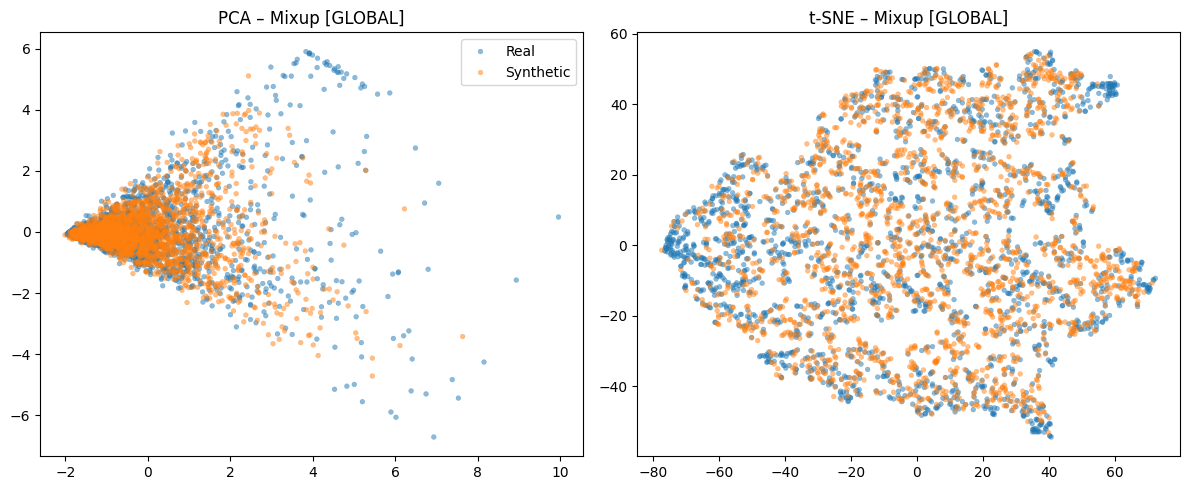


DISTRIBUTION METRICS — Mixup [GLOBAL]
Delta   : KS=0.1381, p=0.0000   ✗ Different
Theta   : KS=0.1263, p=0.0000   ✗ Different
Alpha   : KS=0.1324, p=0.0000   ✗ Different
Beta    : KS=0.1212, p=0.0000   ✗ Different
Gamma   : KS=0.1361, p=0.0000   ✗ Different
MMD: -0.343235

REAL-vs-SYN CLASSIFIER — Mixup [GLOBAL]
Accuracy: 0.6879
Confusion Matrix:
 [[6655 2508]
 [3173 5866]]

TSTR / TRTR — Mixup [GLOBAL]
TRTR: 0.7527
TSTR: 0.4828
Gap : 0.2699

CONDITION S1 — Mixup
  Samples: real=10240, syn=10240


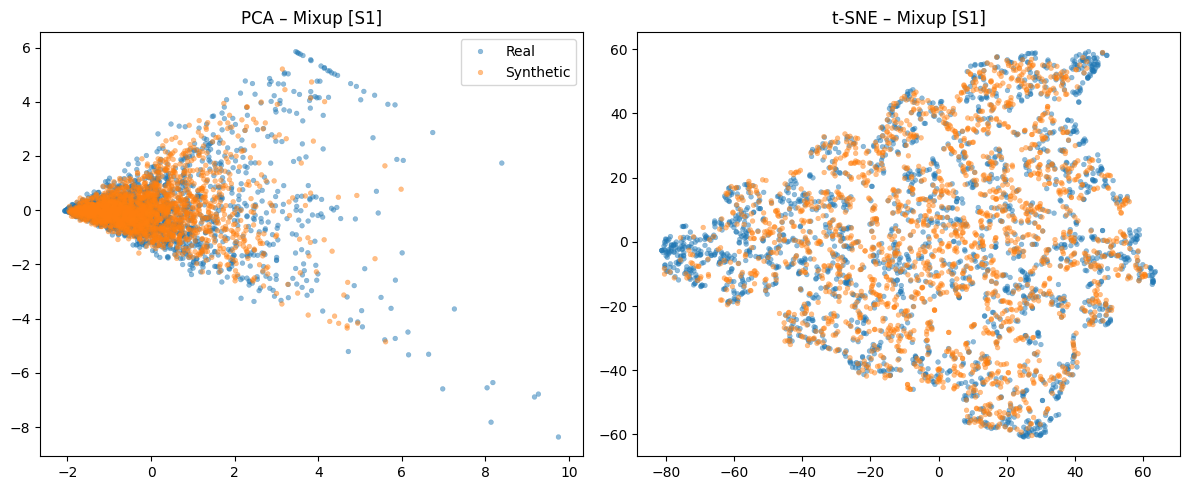


DISTRIBUTION METRICS — Mixup [S1]
Delta   : KS=0.1423, p=0.0000   ✗ Different
Theta   : KS=0.1263, p=0.0000   ✗ Different
Alpha   : KS=0.1357, p=0.0000   ✗ Different
Beta    : KS=0.1239, p=0.0000   ✗ Different
Gamma   : KS=0.1388, p=0.0000   ✗ Different
MMD: -0.287355

REAL-vs-SYN CLASSIFIER — Mixup [S1]
Accuracy: 0.6779
Confusion Matrix:
 [[2245  832]
 [1147 1920]]

TSTR / TRTR — Mixup [S1]
TRTR: 0.7122
TSTR: 0.4645
Gap : 0.2477

CONDITION S2_match — Mixup
  Samples: real=10176, syn=10176


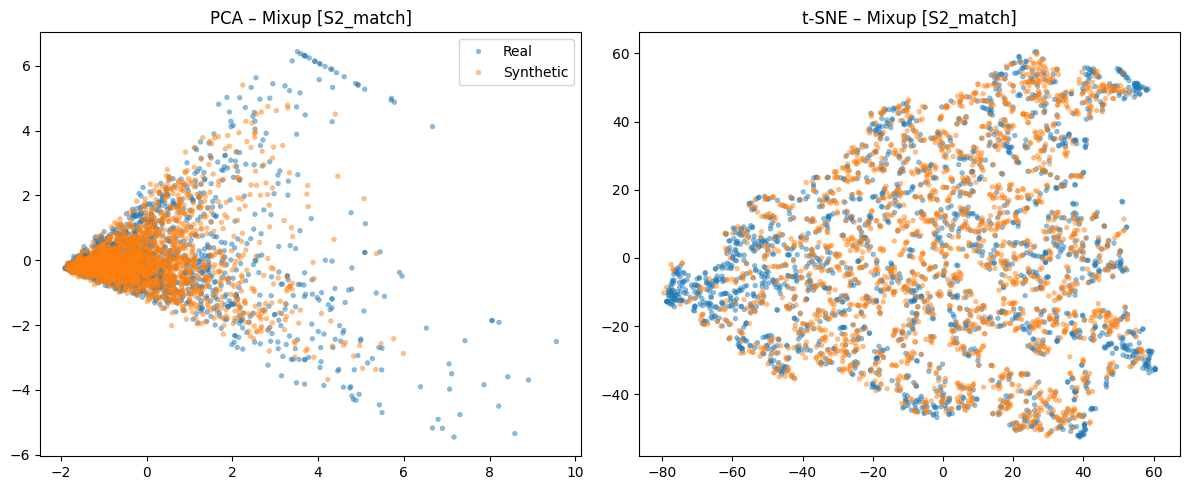


DISTRIBUTION METRICS — Mixup [S2_match]
Delta   : KS=0.1394, p=0.0000   ✗ Different
Theta   : KS=0.1279, p=0.0000   ✗ Different
Alpha   : KS=0.1370, p=0.0000   ✗ Different
Beta    : KS=0.1268, p=0.0000   ✗ Different
Gamma   : KS=0.1349, p=0.0000   ✗ Different
MMD: -0.208404

REAL-vs-SYN CLASSIFIER — Mixup [S2_match]
Accuracy: 0.7134
Confusion Matrix:
 [[2245  772]
 [ 978 2111]]

TSTR / TRTR — Mixup [S2_match]
TRTR: 0.7986
TSTR: 0.5080
Gap : 0.2905

CONDITION S2_nomatch — Mixup
  Samples: real=9920, syn=9920


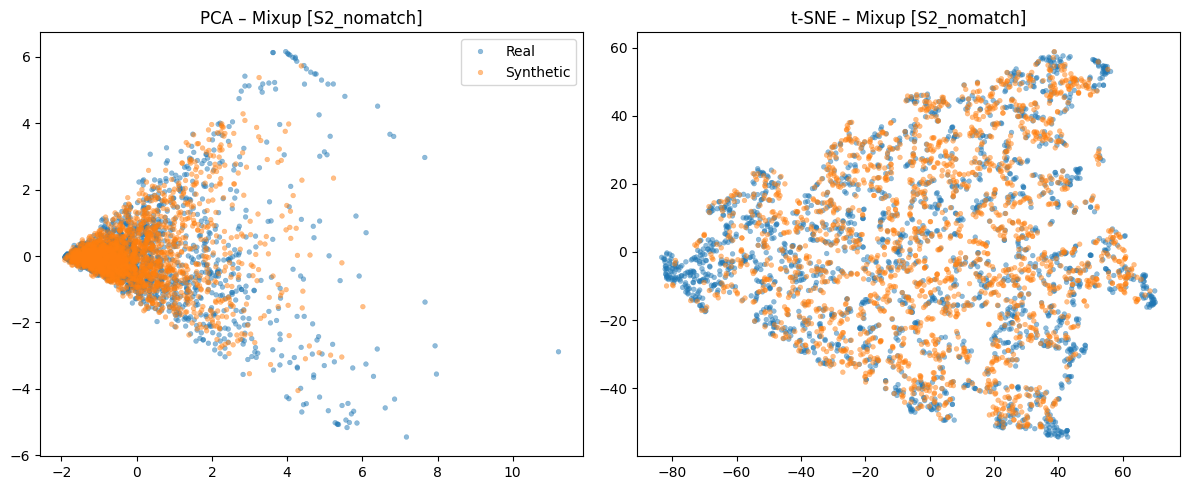


DISTRIBUTION METRICS — Mixup [S2_nomatch]
Delta   : KS=0.1377, p=0.0000   ✗ Different
Theta   : KS=0.1290, p=0.0000   ✗ Different
Alpha   : KS=0.1316, p=0.0000   ✗ Different
Beta    : KS=0.1202, p=0.0000   ✗ Different
Gamma   : KS=0.1393, p=0.0000   ✗ Different
MMD: -0.233051

REAL-vs-SYN CLASSIFIER — Mixup [S2_nomatch]
Accuracy: 0.6851
Confusion Matrix:
 [[2131  830]
 [1044 1947]]

TSTR / TRTR — Mixup [S2_nomatch]
TRTR: 0.7715
TSTR: 0.5060
Gap : 0.2655


In [56]:
mixup_results = evaluate_model_step_by_step("mixup")

### 4.2.2. Correlation Sampling Model Evaluation


################################################################################
EVALUATING MODEL: Correlation Sampling (corr)
################################################################################

[corr] real condition counts: {'S1': 10240, 'S2_match': 10176, 'S2_nomatch': 9920}
[corr] syn  condition counts: {'S1': 10240, 'S2_match': 10176, 'S2_nomatch': 9920}
  [S1] counts — real=10240, syn=10240
  [S2_match] counts — real=10176, syn=10176
  [S2_nomatch] counts — real=9920, syn=9920


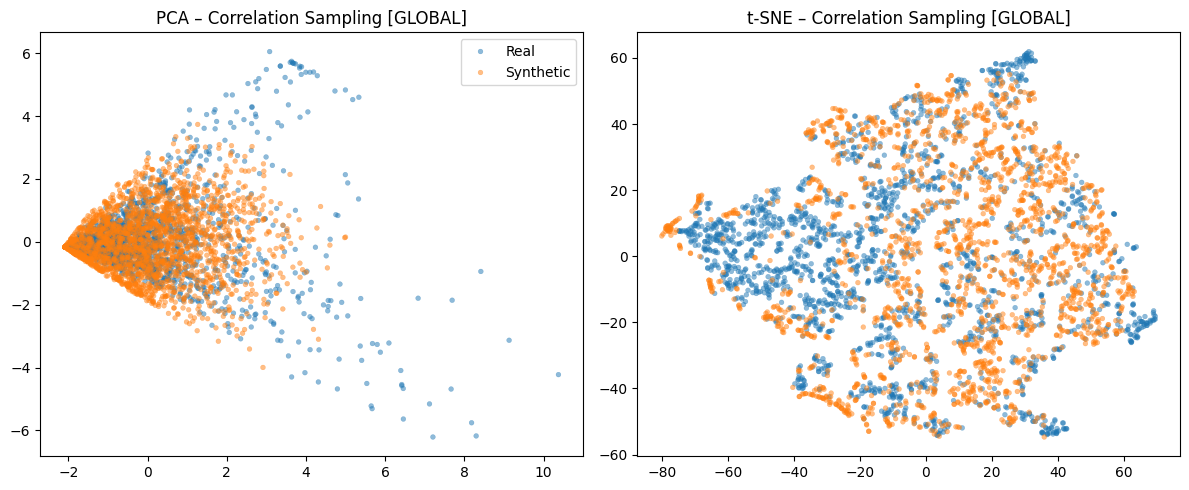


DISTRIBUTION METRICS — Correlation Sampling [GLOBAL]
Delta   : KS=0.2536, p=0.0000   ✗ Different
Theta   : KS=0.2176, p=0.0000   ✗ Different
Alpha   : KS=0.2360, p=0.0000   ✗ Different
Beta    : KS=0.1644, p=0.0000   ✗ Different
Gamma   : KS=0.2495, p=0.0000   ✗ Different
MMD: -0.428586

REAL-vs-SYN CLASSIFIER — Correlation Sampling [GLOBAL]
Accuracy: 0.8977
Confusion Matrix:
 [[8071 1092]
 [ 770 8269]]

TSTR / TRTR — Correlation Sampling [GLOBAL]
TRTR: 0.7527
TSTR: 0.4913
Gap : 0.2614

CONDITION S1 — Correlation Sampling
  Samples: real=10240, syn=10240


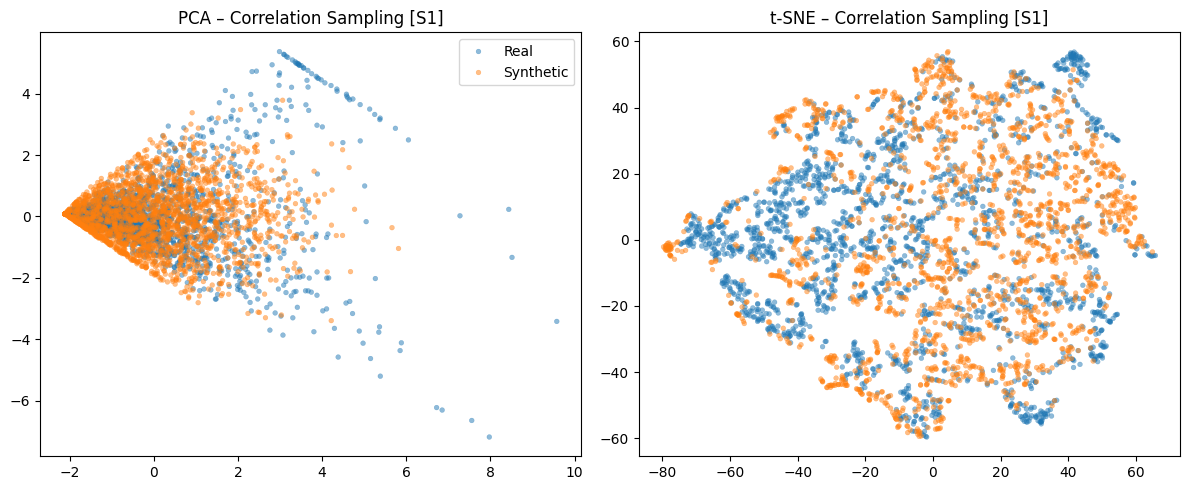


DISTRIBUTION METRICS — Correlation Sampling [S1]
Delta   : KS=0.2378, p=0.0000   ✗ Different
Theta   : KS=0.2174, p=0.0000   ✗ Different
Alpha   : KS=0.2232, p=0.0000   ✗ Different
Beta    : KS=0.1495, p=0.0000   ✗ Different
Gamma   : KS=0.2487, p=0.0000   ✗ Different
MMD: -0.371892

REAL-vs-SYN CLASSIFIER — Correlation Sampling [S1]
Accuracy: 0.8856
Confusion Matrix:
 [[2686  391]
 [ 312 2755]]

TSTR / TRTR — Correlation Sampling [S1]
TRTR: 0.7122
TSTR: 0.5124
Gap : 0.1999

CONDITION S2_match — Correlation Sampling
  Samples: real=10176, syn=10176


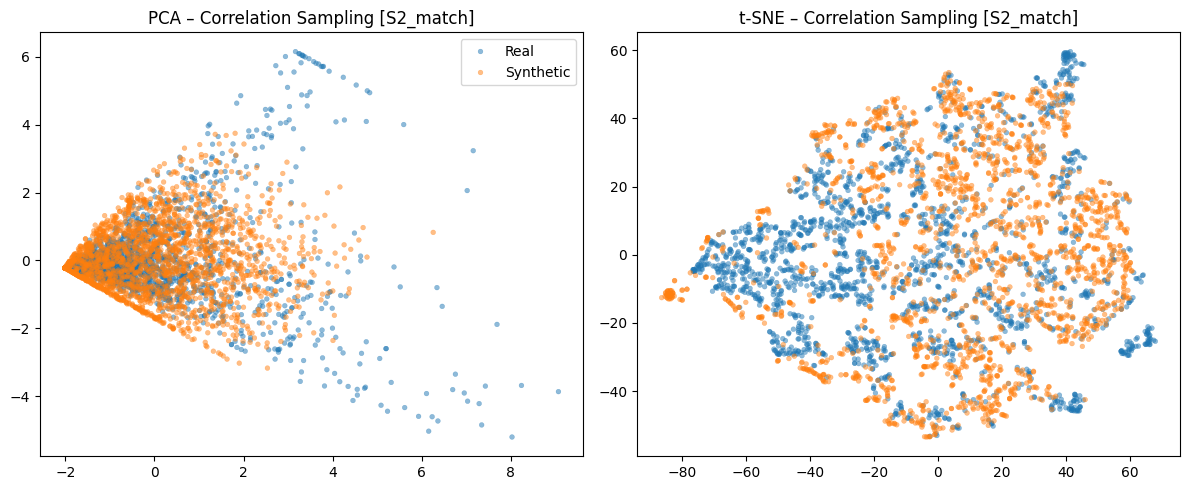


DISTRIBUTION METRICS — Correlation Sampling [S2_match]
Delta   : KS=0.2657, p=0.0000   ✗ Different
Theta   : KS=0.2222, p=0.0000   ✗ Different
Alpha   : KS=0.2566, p=0.0000   ✗ Different
Beta    : KS=0.1676, p=0.0000   ✗ Different
Gamma   : KS=0.2495, p=0.0000   ✗ Different
MMD: -0.398181

REAL-vs-SYN CLASSIFIER — Correlation Sampling [S2_match]
Accuracy: 0.9114
Confusion Matrix:
 [[2704  313]
 [ 228 2861]]

TSTR / TRTR — Correlation Sampling [S2_match]
TRTR: 0.7986
TSTR: 0.4874
Gap : 0.3112

CONDITION S2_nomatch — Correlation Sampling
  Samples: real=9920, syn=9920


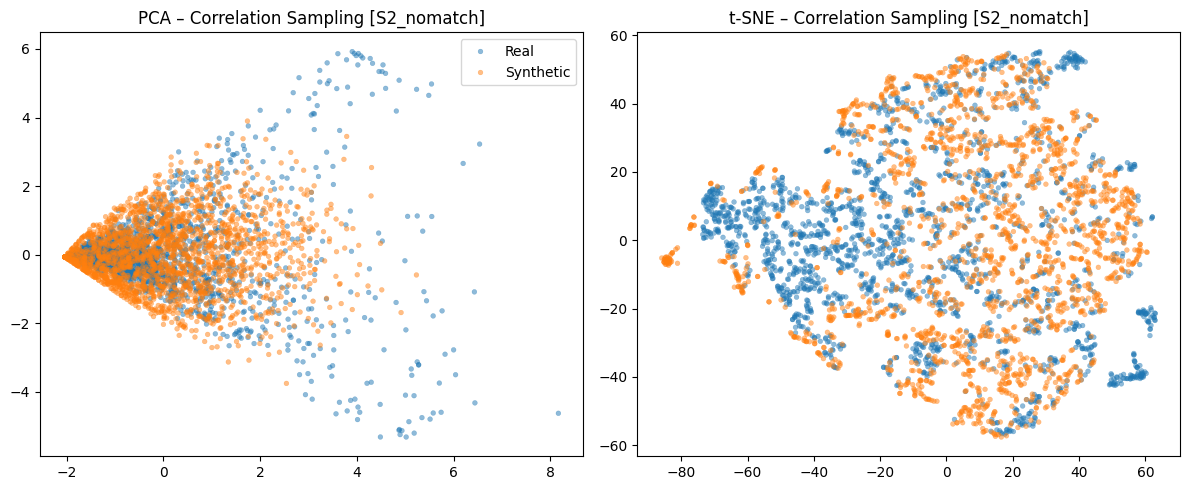


DISTRIBUTION METRICS — Correlation Sampling [S2_nomatch]
Delta   : KS=0.2576, p=0.0000   ✗ Different
Theta   : KS=0.2131, p=0.0000   ✗ Different
Alpha   : KS=0.2279, p=0.0000   ✗ Different
Beta    : KS=0.1772, p=0.0000   ✗ Different
Gamma   : KS=0.2502, p=0.0000   ✗ Different
MMD: -0.381798

REAL-vs-SYN CLASSIFIER — Correlation Sampling [S2_nomatch]
Accuracy: 0.9015
Confusion Matrix:
 [[2626  335]
 [ 251 2740]]

TSTR / TRTR — Correlation Sampling [S2_nomatch]
TRTR: 0.7715
TSTR: 0.4785
Gap : 0.2930


In [57]:
corr_results = evaluate_model_step_by_step("corr")

### 4.2.3. WGAN-GP Model Evaluation


################################################################################
EVALUATING MODEL: WGAN-GP (wgangp)
################################################################################

[wgangp] real condition counts: {'S1': 10240, 'S2_match': 10176, 'S2_nomatch': 9920}
[wgangp] syn  condition counts: {'S1': 10240, 'S2_match': 10176, 'S2_nomatch': 9920}
  [S1] counts — real=10240, syn=10240
  [S2_match] counts — real=10176, syn=10176
  [S2_nomatch] counts — real=9920, syn=9920


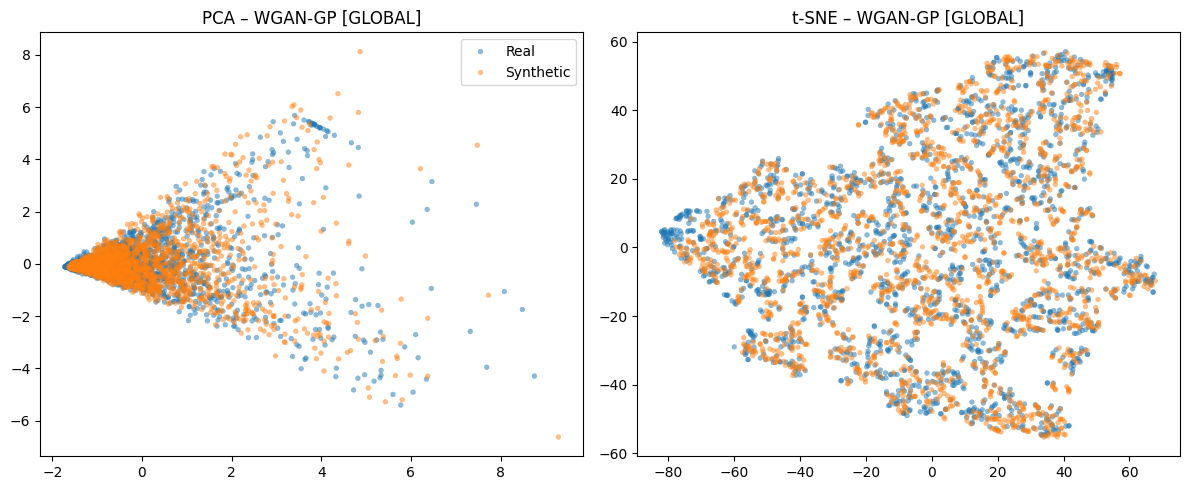


DISTRIBUTION METRICS — WGAN-GP [GLOBAL]
Delta   : KS=0.0138, p=0.0059   ✗ Different
Theta   : KS=0.0409, p=0.0000   ✗ Different
Alpha   : KS=0.0275, p=0.0000   ✗ Different
Beta    : KS=0.0315, p=0.0000   ✗ Different
Gamma   : KS=0.0480, p=0.0000   ✗ Different
MMD: -0.241229

REAL-vs-SYN CLASSIFIER — WGAN-GP [GLOBAL]
Accuracy: 0.6598
Confusion Matrix:
 [[5904 3259]
 [2933 6106]]

TSTR / TRTR — WGAN-GP [GLOBAL]
TRTR: 0.7527
TSTR: 0.5036
Gap : 0.2491

CONDITION S1 — WGAN-GP
  Samples: real=10240, syn=10240


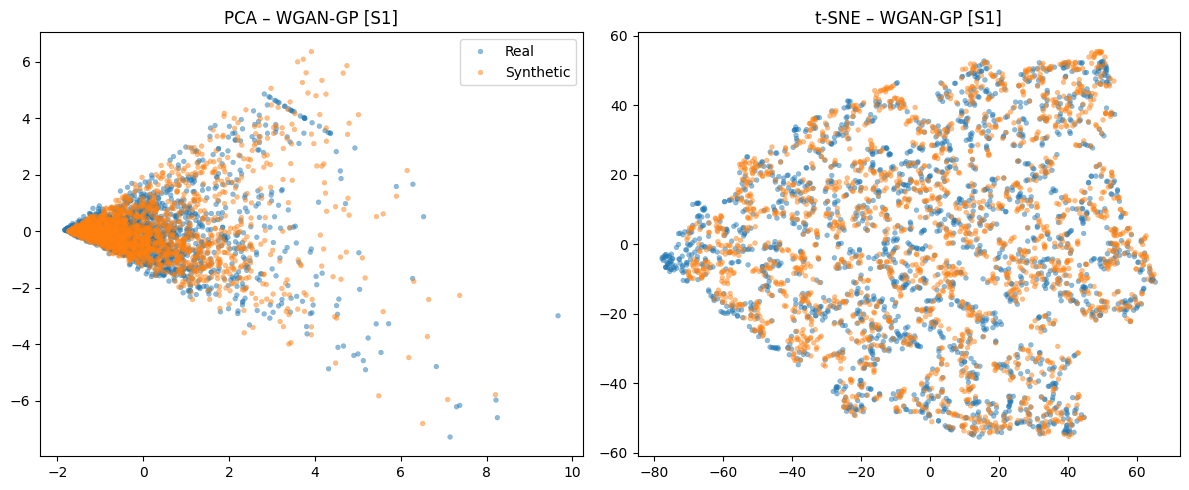


DISTRIBUTION METRICS — WGAN-GP [S1]
Delta   : KS=0.0511, p=0.0000   ✗ Different
Theta   : KS=0.0456, p=0.0000   ✗ Different
Alpha   : KS=0.0268, p=0.0013   ✗ Different
Beta    : KS=0.0220, p=0.0140   ✗ Different
Gamma   : KS=0.0291, p=0.0003   ✗ Different
MMD: -0.176048

REAL-vs-SYN CLASSIFIER — WGAN-GP [S1]
Accuracy: 0.6698
Confusion Matrix:
 [[2127  950]
 [1079 1988]]

TSTR / TRTR — WGAN-GP [S1]
TRTR: 0.7122
TSTR: 0.5114
Gap : 0.2008

CONDITION S2_match — WGAN-GP
  Samples: real=10176, syn=10176


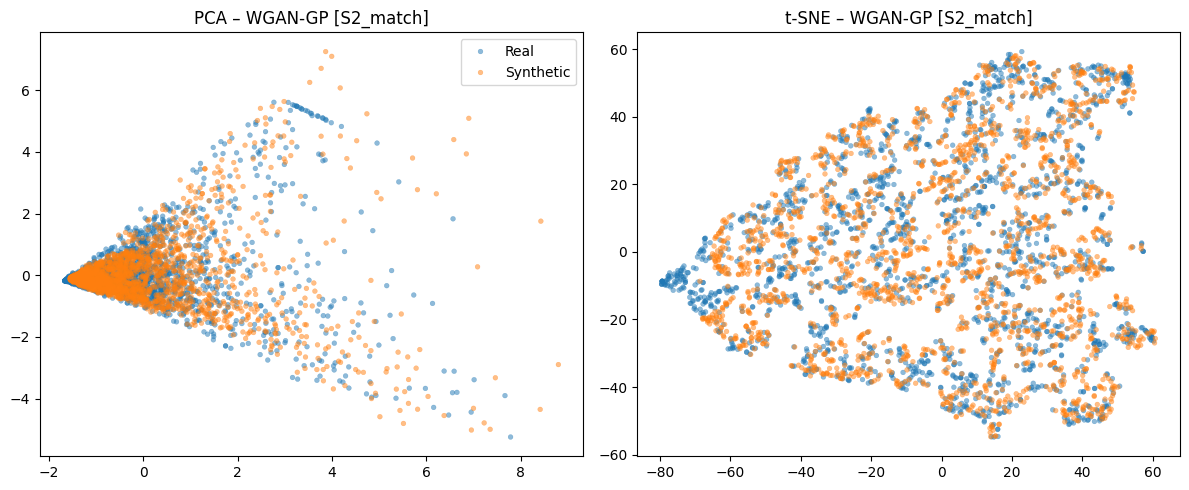


DISTRIBUTION METRICS — WGAN-GP [S2_match]
Delta   : KS=0.0256, p=0.0024   ✗ Different
Theta   : KS=0.0505, p=0.0000   ✗ Different
Alpha   : KS=0.0176, p=0.0848   ✓ Similar
Beta    : KS=0.0540, p=0.0000   ✗ Different
Gamma   : KS=0.0807, p=0.0000   ✗ Different
MMD: -0.128904

REAL-vs-SYN CLASSIFIER — WGAN-GP [S2_match]
Accuracy: 0.7447
Confusion Matrix:
 [[2275  742]
 [ 817 2272]]

TSTR / TRTR — WGAN-GP [S2_match]
TRTR: 0.7986
TSTR: 0.4946
Gap : 0.3040

CONDITION S2_nomatch — WGAN-GP
  Samples: real=9920, syn=9920


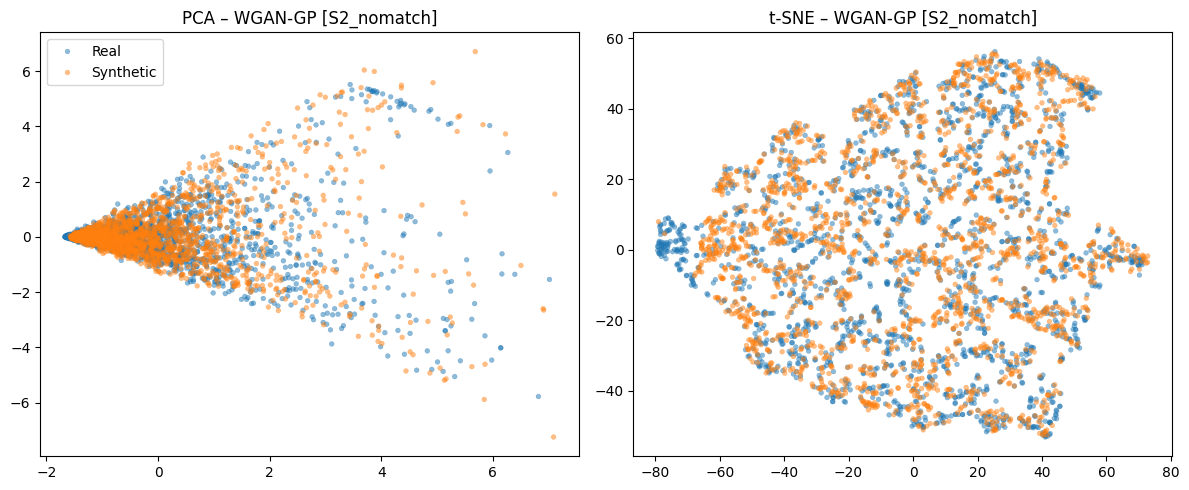


DISTRIBUTION METRICS — WGAN-GP [S2_nomatch]
Delta   : KS=0.0141, p=0.2766   ✓ Similar
Theta   : KS=0.0593, p=0.0000   ✗ Different
Alpha   : KS=0.0776, p=0.0000   ✗ Different
Beta    : KS=0.0277, p=0.0010   ✗ Different
Gamma   : KS=0.0757, p=0.0000   ✗ Different
MMD: -0.165995

REAL-vs-SYN CLASSIFIER — WGAN-GP [S2_nomatch]
Accuracy: 0.7014
Confusion Matrix:
 [[2058  903]
 [ 874 2117]]

TSTR / TRTR — WGAN-GP [S2_nomatch]
TRTR: 0.7715
TSTR: 0.4879
Gap : 0.2836


In [58]:
wgangp_results = evaluate_model_step_by_step("wgangp")

### 4.2.4. Gaussian Copula Sampling Model Evaluation


################################################################################
EVALUATING MODEL: Gaussian Copula (copula)
################################################################################

[copula] real condition counts: {'S1': 10240, 'S2_match': 10176, 'S2_nomatch': 9920}
[copula] syn  condition counts: {'S1': 10240, 'S2_match': 10176, 'S2_nomatch': 9920}
  [S1] counts — real=10240, syn=10240
  [S2_match] counts — real=10176, syn=10176
  [S2_nomatch] counts — real=9920, syn=9920


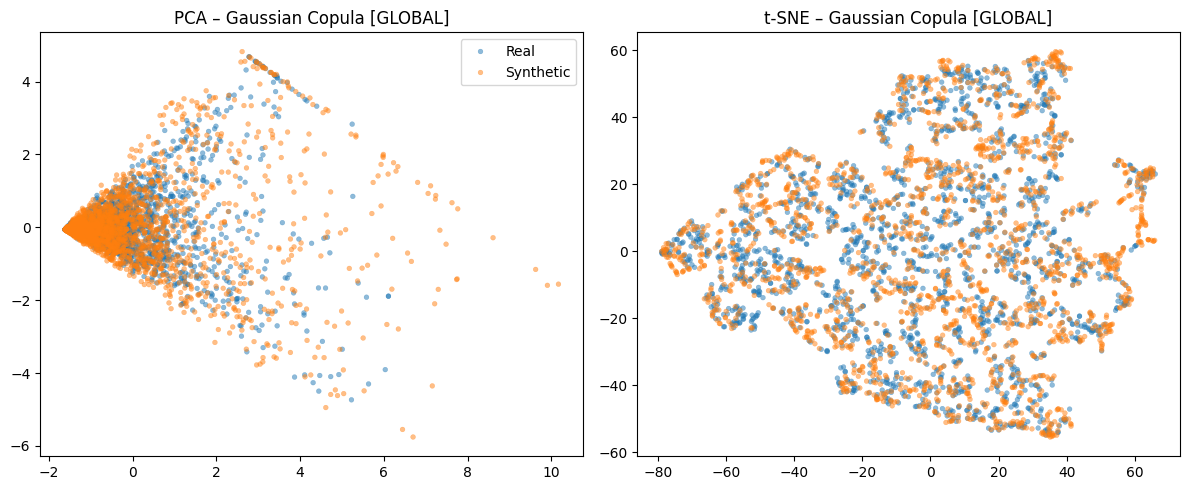


DISTRIBUTION METRICS — Gaussian Copula [GLOBAL]
Delta   : KS=0.0546, p=0.0000   ✗ Different
Theta   : KS=0.0476, p=0.0000   ✗ Different
Alpha   : KS=0.0443, p=0.0000   ✗ Different
Beta    : KS=0.0560, p=0.0000   ✗ Different
Gamma   : KS=0.0541, p=0.0000   ✗ Different
MMD: -0.267701

REAL-vs-SYN CLASSIFIER — Gaussian Copula [GLOBAL]
Accuracy: 0.6537
Confusion Matrix:
 [[5373 3790]
 [2514 6525]]

TSTR / TRTR — Gaussian Copula [GLOBAL]
TRTR: 0.7527
TSTR: 0.6815
Gap : 0.0712

CONDITION S1 — Gaussian Copula
  Samples: real=10240, syn=10240


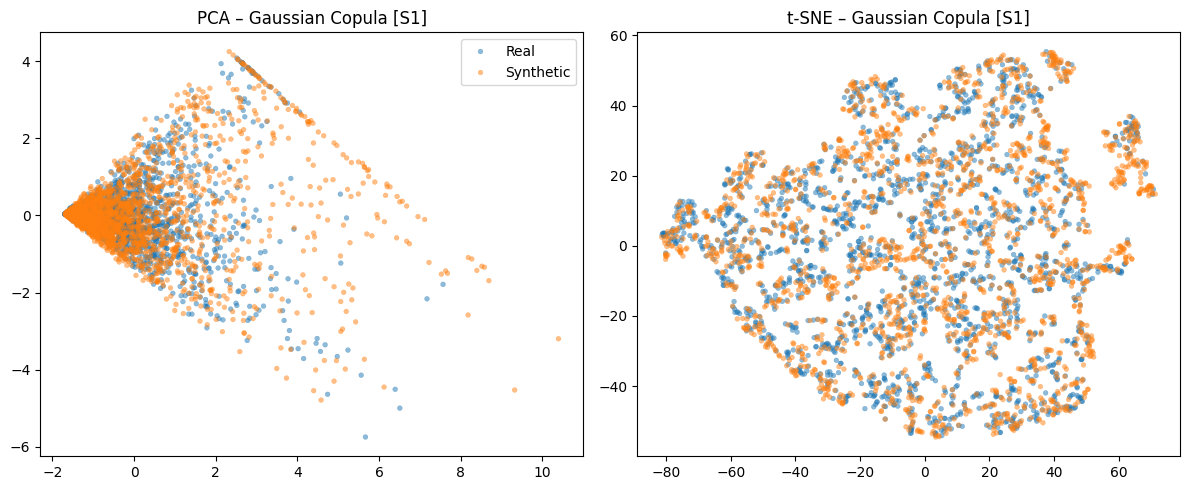


DISTRIBUTION METRICS — Gaussian Copula [S1]
Delta   : KS=0.0451, p=0.0000   ✗ Different
Theta   : KS=0.0484, p=0.0000   ✗ Different
Alpha   : KS=0.0369, p=0.0000   ✗ Different
Beta    : KS=0.0678, p=0.0000   ✗ Different
Gamma   : KS=0.0620, p=0.0000   ✗ Different
MMD: -0.202198

REAL-vs-SYN CLASSIFIER — Gaussian Copula [S1]
Accuracy: 0.6257
Confusion Matrix:
 [[1765 1312]
 [ 988 2079]]

TSTR / TRTR — Gaussian Copula [S1]
TRTR: 0.7122
TSTR: 0.6676
Gap : 0.0446

CONDITION S2_match — Gaussian Copula
  Samples: real=10176, syn=10176


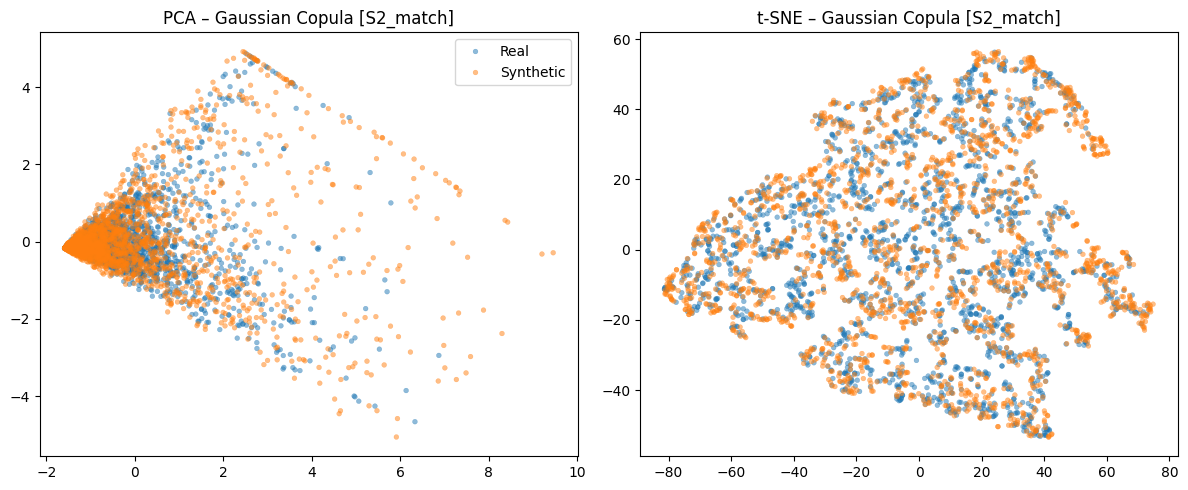


DISTRIBUTION METRICS — Gaussian Copula [S2_match]
Delta   : KS=0.0735, p=0.0000   ✗ Different
Theta   : KS=0.0614, p=0.0000   ✗ Different
Alpha   : KS=0.0648, p=0.0000   ✗ Different
Beta    : KS=0.0530, p=0.0000   ✗ Different
Gamma   : KS=0.0472, p=0.0000   ✗ Different
MMD: -0.220637

REAL-vs-SYN CLASSIFIER — Gaussian Copula [S2_match]
Accuracy: 0.6728
Confusion Matrix:
 [[1884 1133]
 [ 865 2224]]

TSTR / TRTR — Gaussian Copula [S2_match]
TRTR: 0.7986
TSTR: 0.7082
Gap : 0.0904

CONDITION S2_nomatch — Gaussian Copula
  Samples: real=9920, syn=9920


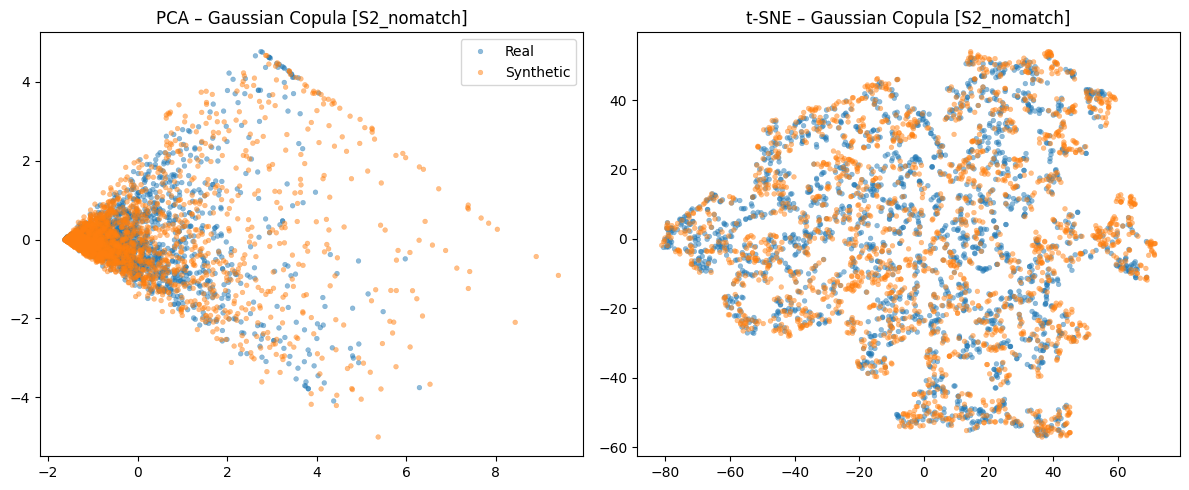


DISTRIBUTION METRICS — Gaussian Copula [S2_nomatch]
Delta   : KS=0.0642, p=0.0000   ✗ Different
Theta   : KS=0.0425, p=0.0000   ✗ Different
Alpha   : KS=0.0365, p=0.0000   ✗ Different
Beta    : KS=0.0569, p=0.0000   ✗ Different
Gamma   : KS=0.0564, p=0.0000   ✗ Different
MMD: -0.271732

REAL-vs-SYN CLASSIFIER — Gaussian Copula [S2_nomatch]
Accuracy: 0.6542
Confusion Matrix:
 [[1765 1196]
 [ 862 2129]]

TSTR / TRTR — Gaussian Copula [S2_nomatch]
TRTR: 0.7715
TSTR: 0.7019
Gap : 0.0696


In [59]:
copula_results = evaluate_model_step_by_step("copula")

### 4.2.5. Classwise Interpolation Model Evaluation


################################################################################
EVALUATING MODEL: Classwise Interpolation (interp)
################################################################################

[interp] real condition counts: {'S1': 10240, 'S2_match': 10176, 'S2_nomatch': 9920}
[interp] syn  condition counts: {'S1': 10240, 'S2_match': 10176, 'S2_nomatch': 9920}
  [S1] counts — real=10240, syn=10240
  [S2_match] counts — real=10176, syn=10176
  [S2_nomatch] counts — real=9920, syn=9920


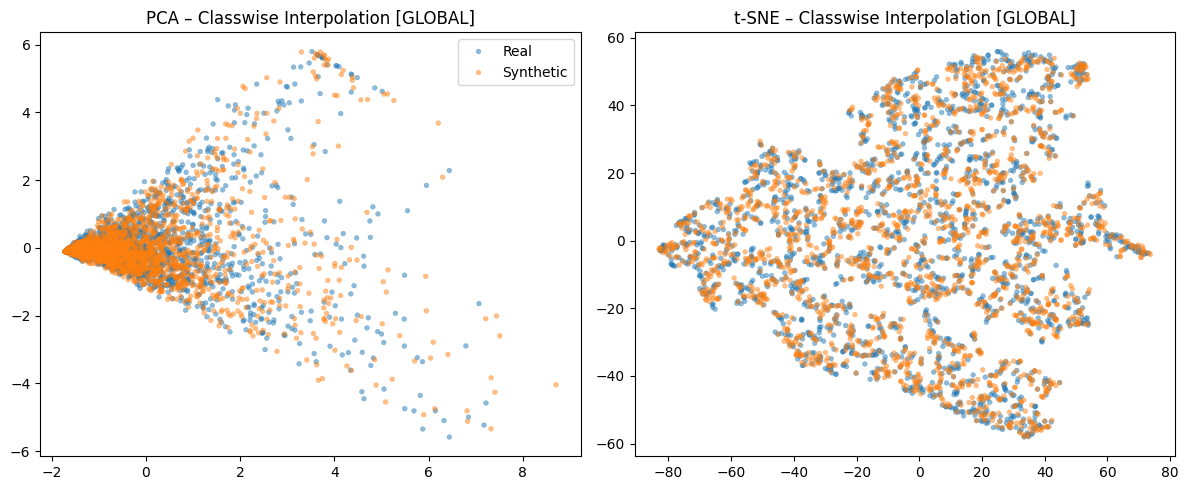


DISTRIBUTION METRICS — Classwise Interpolation [GLOBAL]
Delta   : KS=0.0089, p=0.1765   ✓ Similar
Theta   : KS=0.0101, p=0.0907   ✓ Similar
Alpha   : KS=0.0084, p=0.2289   ✓ Similar
Beta    : KS=0.0119, p=0.0277   ✗ Different
Gamma   : KS=0.0129, p=0.0125   ✗ Different
MMD: -0.248633

REAL-vs-SYN CLASSIFIER — Classwise Interpolation [GLOBAL]
Accuracy: 0.5083
Confusion Matrix:
 [[5029 4134]
 [4816 4223]]

TSTR / TRTR — Classwise Interpolation [GLOBAL]
TRTR: 0.7527
TSTR: 0.7917
Gap : 0.0390

CONDITION S1 — Classwise Interpolation
  Samples: real=10240, syn=10240


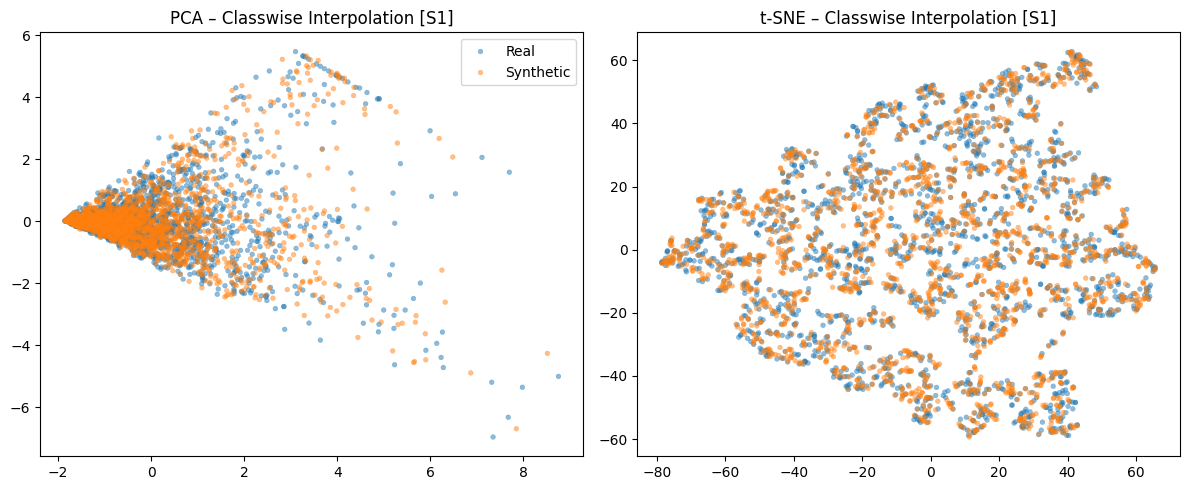


DISTRIBUTION METRICS — Classwise Interpolation [S1]
Delta   : KS=0.0093, p=0.7666   ✓ Similar
Theta   : KS=0.0123, p=0.4170   ✓ Similar
Alpha   : KS=0.0100, p=0.6860   ✓ Similar
Beta    : KS=0.0142, p=0.2537   ✓ Similar
Gamma   : KS=0.0254, p=0.0027   ✗ Different
MMD: -0.205496

REAL-vs-SYN CLASSIFIER — Classwise Interpolation [S1]
Accuracy: 0.4557
Confusion Matrix:
 [[1523 1554]
 [1790 1277]]

TSTR / TRTR — Classwise Interpolation [S1]
TRTR: 0.7122
TSTR: 0.7887
Gap : 0.0765

CONDITION S2_match — Classwise Interpolation
  Samples: real=10176, syn=10176


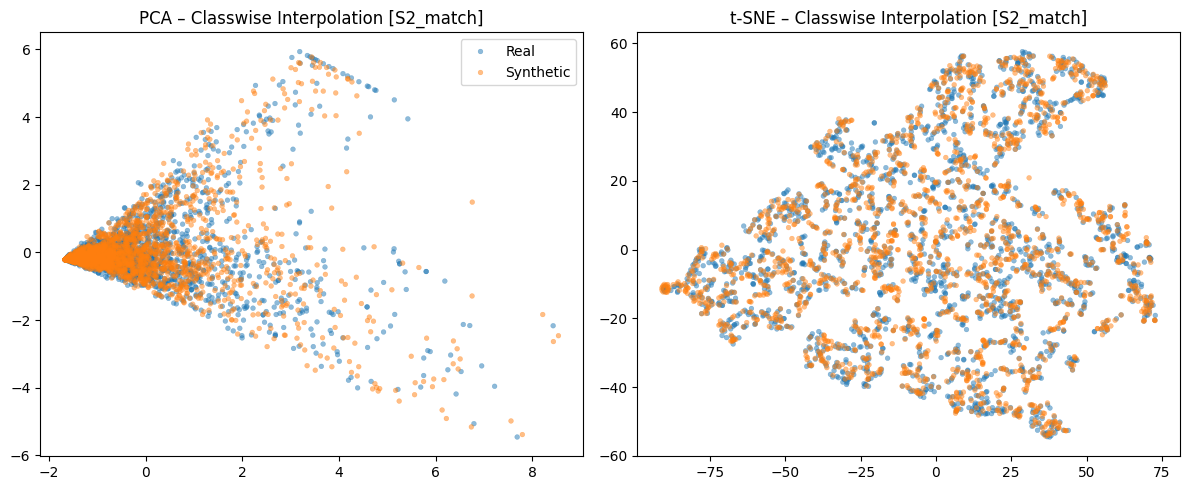


DISTRIBUTION METRICS — Classwise Interpolation [S2_match]
Delta   : KS=0.0131, p=0.3467   ✓ Similar
Theta   : KS=0.0101, p=0.6705   ✓ Similar
Alpha   : KS=0.0108, p=0.5880   ✓ Similar
Beta    : KS=0.0100, p=0.6823   ✓ Similar
Gamma   : KS=0.0180, p=0.0735   ✓ Similar
MMD: -0.126825

REAL-vs-SYN CLASSIFIER — Classwise Interpolation [S2_match]
Accuracy: 0.5029
Confusion Matrix:
 [[1604 1413]
 [1622 1467]]

TSTR / TRTR — Classwise Interpolation [S2_match]
TRTR: 0.7986
TSTR: 0.8290
Gap : 0.0305

CONDITION S2_nomatch — Classwise Interpolation
  Samples: real=9920, syn=9920


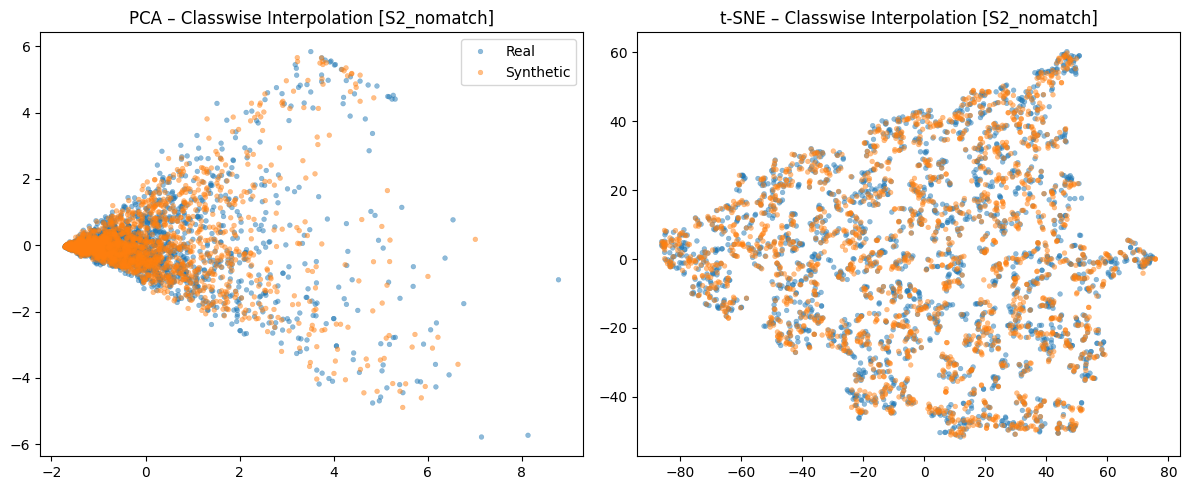


DISTRIBUTION METRICS — Classwise Interpolation [S2_nomatch]
Delta   : KS=0.0121, p=0.4624   ✓ Similar
Theta   : KS=0.0121, p=0.4624   ✓ Similar
Alpha   : KS=0.0121, p=0.4624   ✓ Similar
Beta    : KS=0.0145, p=0.2468   ✓ Similar
Gamma   : KS=0.0123, p=0.4412   ✓ Similar
MMD: -0.158440

REAL-vs-SYN CLASSIFIER — Classwise Interpolation [S2_nomatch]
Accuracy: 0.4911
Confusion Matrix:
 [[1595 1366]
 [1663 1328]]

TSTR / TRTR — Classwise Interpolation [S2_nomatch]
TRTR: 0.7715
TSTR: 0.8216
Gap : 0.0501


In [60]:
interp_results = evaluate_model_step_by_step("interp")

## 4.3. Save evaluation metrics

In [ ]:
def _to_py(obj):
    if isinstance(obj, np.generic):
        return obj.item()
    if isinstance(obj, (list, tuple)):
        return [_to_py(x) for x in obj]
    if isinstance(obj, dict):
        return {k: _to_py(v) for k, v in obj.items()}
    return obj

def save_model_results_to_json(model_key: str, results: dict):
    model_name = MODEL_INFO[model_key]
    model_dir = EVAL_BASE / model_key
    model_dir.mkdir(parents=True, exist_ok=True)

    # GLOBAL
    g = results["global"]
    global_payload = {
        "model_key": model_key,
        "model_name": model_name,
        "scope": "global",
        "condition": None,
        "distribution": {
            "ks": [
                {"band": band, "ks": float(ks_val), "p": float(p_val)}
                for (band, ks_val, p_val) in g["ks"]
            ],
            "mmd": float(g["mmd"]),
        },
        "classification": {
            "real_vs_syn_acc": float(g["rvs_acc"]),
            "trtr": float(g["trtr"]),
            "tstr": float(g["tstr"]),
            "gap": float(g["gap"]),
        },
    }

    with open(model_dir / "global.json", "w") as f:
        json.dump(_to_py(global_payload), f, indent=2)

    # CONDITIONS
    for cond in CANONICAL_CONDITIONS:
        c_res = results["condition"].get(cond)
        if c_res is None:
            continue

        cond_payload = {
            "model_key": model_key,
            "model_name": model_name,
            "scope": "condition",
            "condition": cond,
            "distribution": {
                "ks": [
                    {"band": band, "ks": float(ks_val), "p": float(p_val)}
                    for (band, ks_val, p_val) in c_res["ks"]
                ],
                "mmd": float(c_res["mmd"]),
            },
            "classification": {
                "real_vs_syn_acc": float(c_res["rvs_acc"]),
                "trtr": float(c_res["trtr"]),
                "tstr": float(c_res["tstr"]),
                "gap": float(c_res["gap"]),
            },
            "sample_sizes": {
                "n_real": int(c_res["N_real"]),
                "n_syn": int(c_res["N_syn"]),
            },
        }

        fname = f"{cond}.json"
        with open(model_dir / fname, "w") as f:
            json.dump(_to_py(cond_payload), f, indent=2)

    print(f"[SAVED] JSON evaluation for {model_name}: {model_dir}")

In [ ]:
all_results = {
    "mixup":  mixup_results,
    "corr":   corr_results,
    "wgangp": wgangp_results,
    "copula": copula_results,
    "interp": interp_results,
}
for k, res in all_results.items():
    save_model_results_to_json(k, res)

[SAVED] JSON evaluation for Mixup: ../output/synthetic_evaluation/mixup
[SAVED] JSON evaluation for Correlation Sampling: ../output/synthetic_evaluation/corr
[SAVED] JSON evaluation for WGAN-GP: ../output/synthetic_evaluation/wgangp
[SAVED] JSON evaluation for Gaussian Copula: ../output/synthetic_evaluation/copula
[SAVED] JSON evaluation for Classwise Interpolation: ../output/synthetic_evaluation/interp


## 4.4. Fine-tuning for Best Model